In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchcrf  import CRF
from conllu import parse_incr
import os
from collections import Counter
import matplotlib.pyplot as plt


In [8]:
#######################################
# 1) ЧТЕНИЕ .conllu ФАЙЛА NERUS-LENTA
#######################################

def read_nerus_conllu_limited(file_path, max_sents=10000):
    sentences = []
    
    with open(file_path, "r", encoding="utf-8") as f:
        # parse_incr читает по одному предложению за раз
        for i, tokenlist in enumerate(parse_incr(f), start=1):
            tokens = []
            tags = []
            for token in tokenlist:
                form = token["form"]
                misc = token["misc"]
                
                if not misc:
                    ner_tag = "O"
                else:
                    ner_tag = misc.get("Tag", "O")
                
                tokens.append(form)
                tags.append(ner_tag)
            
            if tokens:
                sentences.append((tokens, tags))
            
            if max_sents != 0 and i >= max_sents:
                break
    
    return sentences


In [9]:

#######################################
# 2) СТРОИМ СЛОВАРИ word2idx / tag2idx
#######################################

def build_vocab(sentences, min_freq=1):
    word_counter = Counter()
    tag_counter = Counter()

    for tokens, tags in sentences:
        word_counter.update(tokens)
        tag_counter.update(tags)

    # Спецтокены
    PAD_TOKEN = "<PAD>"
    UNK_TOKEN = "<UNK>"
    
    # Соберём слова, учитывая min_freq
    words = [w for w, c in word_counter.items() if c >= min_freq]
    
    # Финальный список слов
    vocab = [PAD_TOKEN, UNK_TOKEN] + sorted(words)
    word2idx = {w: i for i, w in enumerate(vocab)}

    # Аналогично для тегов (O, B-PER, ...)
    all_tags = sorted(tag_counter.keys()) 
    tag2idx = {tag: i for i, tag in enumerate(all_tags)}

    return word2idx, tag2idx

In [10]:
#######################################
# 3) TORCH DATASET ДЛЯ BATCH TRAINING
#######################################

class NerusDataset(Dataset):
    def __init__(self, sentences, word2idx, tag2idx, max_len=128):
        self.sentences = sentences
        self.word2idx = word2idx
        self.tag2idx = tag2idx
        self.max_len = max_len
        
        self.PAD_IDX = self.word2idx["<PAD>"]
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        tokens, tags = self.sentences[idx]
        
        # Преобразуем слова -> индексы (с <UNK> где нет слова)
        token_ids = []
        for w in tokens:
            if w in self.word2idx:
                token_ids.append(self.word2idx[w])
            else:
                token_ids.append(self.word2idx["<UNK>"])
        
        # Аналогично для тегов
        tag_ids = [self.tag2idx[t] for t in tags]
        
        # Усечём или заполним паддингом до max_len
        if len(token_ids) > self.max_len:
            token_ids = token_ids[:self.max_len]
            tag_ids = tag_ids[:self.max_len]
        else:
            while len(token_ids) < self.max_len:
                token_ids.append(self.PAD_IDX)
                tag_ids.append(0)

        return torch.tensor(token_ids, dtype=torch.long), torch.tensor(tag_ids, dtype=torch.long)

In [11]:

#######################################
# 4) МОДЕЛЬ BiLSTM+CRF
#######################################

class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=128, hidden_dim=256):
        super(BiLSTM_CRF, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        self.fc = nn.Linear(hidden_dim, tagset_size)
        
        self.crf = CRF(num_tags=tagset_size, batch_first=True)

    def forward(self, x, tags=None, mask=None):
        embeds = self.embedding(x) 
        lstm_out, _ = self.lstm(embeds)
        emissions = self.fc(lstm_out)
        
        if mask is None:
            mask = (x != 0)
        
        if tags is not None:
            # crf() возвращает log-likelihood (log_prob)
            # Чтобы получить loss, берём -log-likelihood
            log_likelihood = self.crf(emissions, tags, mask=mask)
            return -log_likelihood  # чем больше log-likelihood, тем лучше => минус для loss
        else:
            return self.crf.decode(emissions, mask=mask)



Считываем датасет...
Всего предложений: 20000
Пример: (['Вице-премьер', 'по', 'социальным', 'вопросам', 'Татьяна', 'Голикова', 'рассказала', ',', 'в', 'каких', 'регионах', 'России', 'зафиксирована', 'наиболее', 'высокая', 'смертность', 'от', 'рака', ',', 'сообщает', 'РИА', 'Новости', '.'], ['O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'I-ORG', 'O'])
Число токенов в словаре: 53816
Число тегов: 7
Используемое устройство: cuda
Epoch 1/5, loss = 160.0787
Epoch 2/5, loss = 106.5724
Epoch 3/5, loss = 90.5664
Epoch 4/5, loss = 79.0662
Epoch 5/5, loss = 69.6655
Validation loss = 71.5636
              precision    recall  f1-score   support

         LOC       0.84      0.44      0.58      1713
         ORG       0.69      0.33      0.45      1633
         PER       0.66      0.13      0.22      1404

   micro avg       0.76      0.31      0.44      4750
   macro avg       0.73      0.30      0.42      4750
weighted avg

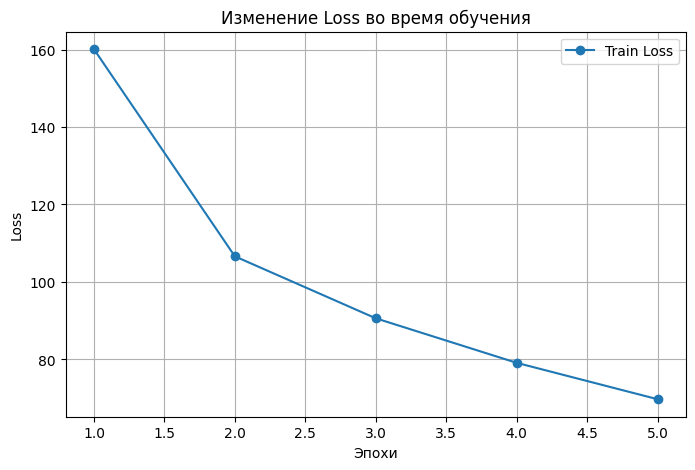

In [12]:


#######################################
# 5) СБОРКА ОБЩЕЙ ЛОГИКИ
#######################################


# Путь к вашему файлу nerus_lenta.conllu
file_path = "nerus_lenta.conllu"
if not os.path.exists(file_path):
    print("Файл nerus_lenta.conllu не найден!")
    exit()
    
print("Считываем датасет...")
sentences = read_nerus_conllu_limited(file_path, max_sents=20000)
print(f"Всего предложений: {len(sentences)}")
    
# Пример одного предложения:
print("Пример:", sentences[0])

# Строим словари
word2idx, tag2idx = build_vocab(sentences, min_freq=1)
    
# Смотрим размеры словарей
print(f"Число токенов в словаре: {len(word2idx)}")
print(f"Число тегов: {len(tag2idx)}")

# Делим на train/val
# Для демо 80% / 20%
train_size = int(0.8 * len(sentences))
train_data = sentences[:train_size]
val_data = sentences[train_size:]

# Создаем Dataset и DataLoader
batch_size = 16
max_len = 128
train_dataset = NerusDataset(train_data, word2idx, tag2idx, max_len=max_len)
val_dataset = NerusDataset(val_data, word2idx, tag2idx, max_len=max_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Определяем устройство (CPU / GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используемое устройство:", device)

# Создаём модель
model = BiLSTM_CRF(
    vocab_size=len(word2idx),
    tagset_size=len(tag2idx),
    embedding_dim=128,
    hidden_dim=256
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5
model.train()
train_losses = []

for epoch in range(num_epochs):
    total_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Обнуляем градиенты
        optimizer.zero_grad()
            
        # Считаем loss
        loss = model(x_batch, tags=y_batch)  # CRF уже вернёт -log_likelihood
        loss.backward()
        optimizer.step()
            
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  # Сохраняем значение Loss
    print(f"Epoch {epoch+1}/{num_epochs}, loss = {avg_loss:.4f}")

###########################################
# 6) ПРОВЕРКА НА ВАЛИДАЦИИ (минимальный код)
###########################################
model.eval()
val_loss = 0.0
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        loss = model(x_batch, tags=y_batch)
        val_loss += loss.item()

val_loss /= len(val_loader)
print(f"Validation loss = {val_loss:.4f}")

from seqeval.metrics import classification_report

idx2tag = {idx: tag for tag, idx in tag2idx.items()}

model.eval()
true_labels = []
pred_labels = []

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        mask = (x_batch != 0).to(device)
        predictions = model(x_batch, mask=mask)

        # Преобразуем индексы в текстовые метки
        for i in range(len(predictions)):
            true_seq = [idx2tag[y.item()] for y in y_batch[i] if y.item() in idx2tag]
            pred_seq = [idx2tag[p] for p in predictions[i] if p in idx2tag]

            min_len = min(len(true_seq), len(pred_seq))
            true_labels.append(true_seq[:min_len])
            pred_labels.append(pred_seq[:min_len])

# Выводим метрики качества
print(classification_report(true_labels, pred_labels))

epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.xlabel("Эпохи")
plt.ylabel("Loss")
plt.title("Изменение Loss во время обучения")
plt.legend()
plt.grid()
plt.show()
